In [1]:
import json
import os
import re

from bs4 import BeautifulSoup
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [2]:
connection = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", port=5432)

In [3]:
commit_pct = pd.read_sql("SELECT DISTINCT user_id, package_id, commit_pct FROM open_source.issue_contributors", connection)

In [4]:
language = pd.read_sql("SELECT id as package_id, language FROM open_source.packages", connection)

In [5]:
query = """
SELECT COUNT(*) as total_user_issues, package_id, user_id
FROM open_source.issue_contributors
GROUP BY package_id, user_id
"""

In [6]:
total_user_issues = pd.read_sql(query, connection)

In [7]:
query = """
SELECT COUNT(*) as total_user_comments, package, organization, user_id
FROM open_source.issue_comments
GROUP BY package, organization, user_id
"""

In [8]:
total_user_comments = pd.read_sql(query, connection)

In [9]:
query = """
    SELECT id as package_id, package_name as package, org_name as organization
    FROM open_source.packages
"""

In [10]:
packages = pd.read_sql(query, connection)
package_lookup = dict()
for i in packages.index:
    package_lookup[packages.loc[i]['package_id']] = (packages.loc[i]['package'], packages.loc[i]['organization'])

In [11]:
with open("/home/matt/data/tagtog_requirement_quality_650/requirement_quality/annotations-legend.json", "r") as f:
    annotations_legend = json.load(f)

In [12]:
HTML_DIR = "/home/matt/data/tagtog_requirement_quality_650/requirement_quality/plain.html/pool"
filenames = os.listdir(HTML_DIR)

filename_lookup = dict()
for filename in filenames:
    with open(os.path.join(HTML_DIR, filename)) as f:
        html = BeautifulSoup(f).find("html")
        if html:
            filename_lookup[html['id']] = html['data-origid']

In [13]:
ANNO_DIR = "/home/matt/data/tagtog_requirement_quality_650/requirement_quality/ann.json/master/pool"
filenames = os.listdir(ANNO_DIR)

data = {"issue_id": [], "user_id": [], "package_id":[], "package": [], "organization": []}
for value in annotations_legend.values():
    data[value] = []

for filename in filenames:
    try:
        orig_filename = filename_lookup[filename.replace(".ann.json", "")]
    except KeyError:
        continue
    
    with open(os.path.join(ANNO_DIR, filename), "r") as f:
        labels = json.load(f)
        
    for key, value in annotations_legend.items():
        data[value].append(labels['metas'].get(key, {"value": False})["value"])
    
    
    package_id, user_id, issue_id = tuple(orig_filename.split("-"))
    package, organization = package_lookup[package_id]

    data["package_id"].append(package_id)
    data["issue_id"].append(issue_id)
    data["user_id"].append(user_id)
    data["package"].append(package)
    data["organization"].append(organization)
    
data = pd.DataFrame(data)

In [14]:
github_data = pd.read_csv("../github_data.csv")
similarity_data = pd.read_csv("../similarity_data.csv")
reqs_data = pd.read_csv("~/data/requirement_quality.csv")

reqs_data["user_id"] = reqs_data["user_id"].astype(str)
reqs_data["issue_id"] = reqs_data["issue_id"].astype(str)

In [15]:
data = data.merge(github_data, how="inner", on=["package", "organization", "package_id"])
data = data.merge(reqs_data, how="inner", on=["package_id", "user_id", "issue_id", "package", "organization"])
data = data.merge(total_user_issues, how="inner", on=["package_id", "user_id"])
data = data.merge(total_user_comments, how="inner", on=["package", "organization", "user_id"])
data = data.merge(similarity_data, how="inner", on=["package_id"])
data = data.merge(commit_pct, how="inner", on=["package_id", "user_id"])
data = data.merge(language, how="inner", on=["package_id"])

In [16]:
data["req_quality"] = 0
for key in annotations_legend.values():
    data[key] = data[key].astype(int)
    data["req_quality"] += data[key]

In [17]:
data['issue_length'] = data["body"].apply(lambda x: len(x))

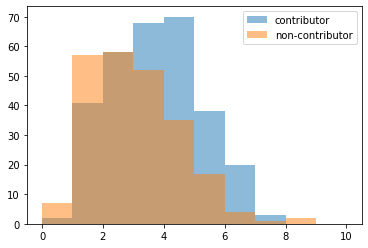

In [18]:
bins = np.linspace(0, 10, 11)

plt.hist(data[data['contributor'] == True]['req_quality'], bins, alpha=0.5, label='contributor')
plt.hist(data[data['contributor'] == False]['req_quality'], bins, alpha=0.5, label='non-contributor')
plt.legend(loc='upper right')
plt.show()

In [19]:
for package_id, count in dict(data['package_id'].value_counts()).items():
    if count > 10:
        data[f"package_{package_id}"] = (data['package_id'] == package_id).astype(int)
    print(f"package_{package_id} - {count}")

package_3fccd9f1b3b0419fa028615e9cf39ed6 - 37
package_ab744db5ca5949d29d101293d7804811 - 32
package_6d8b278d51ff412096368f4a48280546 - 26
package_4d8c8752a3bb4c8a87d04ecf93603f67 - 26
package_170d4a8b6fc64dad8545d46c09cca126 - 24
package_4e4a7c109bdb4d4b8cd175f65e3a0790 - 19
package_6a36e03c0f1441b49faa8f6f78509b9b - 19
package_108f135ddec84117a774448e7e2b49d3 - 17
package_ae03aa731d6c4b93a003d63cd90e7bc2 - 16
package_4db515f7cdac4214a30c071d3c986761 - 15
package_5f0b93551fd94e84b31a0ee1425b8a55 - 14
package_6af468b3b683484e918f236be48cf041 - 13
package_aca070379940455cbca1170e1660d740 - 12
package_4a5b669af00e499592e5dbc9c6e2c1cf - 10
package_b1c8e40c801b46e180494f4908324517 - 10
package_6b45e442fbd14de8ae87462c14b46ee6 - 10
package_6baab5e7e498456bb300a9fd8243591e - 10
package_143dd72ce61147c08edcfb10f625a088 - 9
package_6c49f1fed3bc497b8ee42551fcb7f4df - 9
package_4f9984fc47454f53b9bf762de94e3b27 - 9
package_7ab696761a1f413cbf81ca5e82151e86 - 8
package_98b1acab9bfc47c18897e1f09cee9b

In [20]:
data['package_id'].describe()

count                                  533
unique                                  73
top       3fccd9f1b3b0419fa028615e9cf39ed6
freq                                    37
Name: package_id, dtype: object

In [21]:
data['language'].value_counts()

javascript    188
cpp           125
python        107
java           69
php            44
Name: language, dtype: int64

In [22]:
data['commit_pct_2'] = data['commit_pct']**2
data['similarity_2'] = data['similarity']**2
data['issue_length_2'] = data['issue_length']**2
data['issue_length_3'] = data['issue_length']**3
data['code_blocks'] = data['body'].apply(lambda x: x.count("`"))
data['code_blocks_2'] = data['code_blocks']**2
data['headings'] = data['body'].apply(lambda x: x.count("#"))
data['headings_2'] = data['headings']**2

data['links'] = data['body'].apply(lambda x: x.count("http"))
data['num_words'] = data['body'].apply(lambda x: len(x.split()))
data['num_lines'] = data['body'].apply(lambda x: x.count("\n"))

In [23]:
avg_by_package = data.groupby('package_id').mean()
avg_by_package['package_id'] = avg_by_package.index
avg_by_package.index = range(len(avg_by_package))
avg_by_package['avg_req_quality_package'] = avg_by_package['req_quality']
data = data.merge(avg_by_package[['package_id', 'avg_req_quality_package']], on='package_id', how='inner')

In [24]:
data['avg_req_quality_package_2'] = data['avg_req_quality_package']**2

In [25]:
avg_by_language = data.groupby('language').mean()
avg_by_language['language'] = avg_by_language.index
avg_by_language.index = range(len(avg_by_language))
avg_by_language['avg_req_quality_language'] = avg_by_package['req_quality']
data = data.merge(avg_by_language[['language', 'avg_req_quality_language']], on='language', how='inner')

In [26]:
down_sample = []
for name, group in data.groupby('package_id'):
    if len(group) <= 25:
        down_sample.append(group)
    else:
        down_sample.append(group.sample(25))
down_sample = pd.concat(down_sample)
down_sample.reset_index(inplace=True, drop=True)

In [27]:
down_sample['language'].value_counts()

javascript    179
cpp           113
python        107
java           69
php            44
Name: language, dtype: int64

In [28]:
down_sample['contributor'].value_counts()

True     287
False    225
Name: contributor, dtype: int64

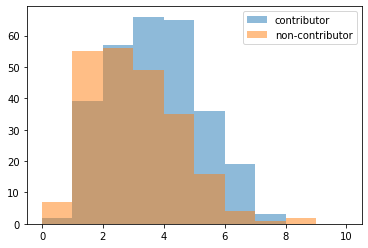

In [29]:
bins = np.linspace(0, 10, 11)

plt.hist(down_sample[down_sample['contributor'] == True]['req_quality'], bins, alpha=0.5, label='contributor')
plt.hist(down_sample[down_sample['contributor'] == False]['req_quality'], bins, alpha=0.5, label='non-contributor')
plt.legend(loc='upper right')
plt.show()

In [30]:
data['cpp'] = (data['language'] == 'cpp').astype(int)

In [38]:
formula = """
req_quality ~ contributor + similarity + language + avg_req_quality_language +
crowd_pct_2 + code_blocks + num_words
"""
y, X = dmatrices(formula, data=data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

11
                            OLS Regression Results                            
Dep. Variable:            req_quality   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     22.75
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           9.60e-33
Time:                        13:58:47   Log-Likelihood:                -893.87
No. Observations:                 533   AIC:                             1808.
Df Residuals:                     523   BIC:                             1851.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept            

Text(0, 0.5, 'Count')

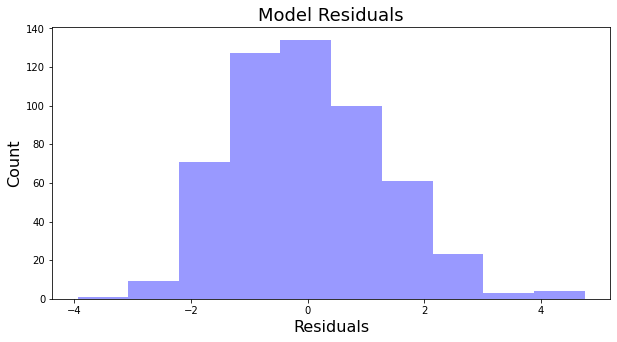

In [37]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=10)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.xlim([-2.2, 2.2])

(-1.0, 10.0)

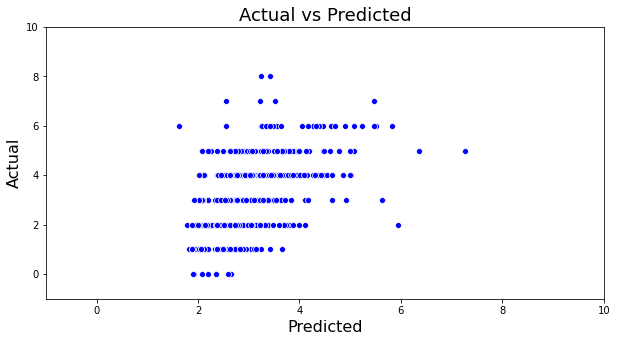

In [32]:
data['predictions'] = res.predict(X)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['predictions'], y=data['req_quality'], color='blue')
plt.title('Actual vs Predicted', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xlim([-1, 10])
plt.ylim([-1, 10])

In [33]:
formula = """
req_quality ~ contributor + avg_req_quality_package + 
total_issues + total_contributors + avg_first_comment +
headings + headings_2 + 
code_blocks + code_blocks_2 + issue_length + issue_length_2 + issue_length_3
"""
y, X = dmatrices(formula, data=data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

13
                            OLS Regression Results                            
Dep. Variable:            req_quality   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     36.28
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           4.37e-61
Time:                        13:57:45   Log-Likelihood:                -819.80
No. Observations:                 533   AIC:                             1666.
Df Residuals:                     520   BIC:                             1721.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept              

Text(0, 0.5, 'Count')

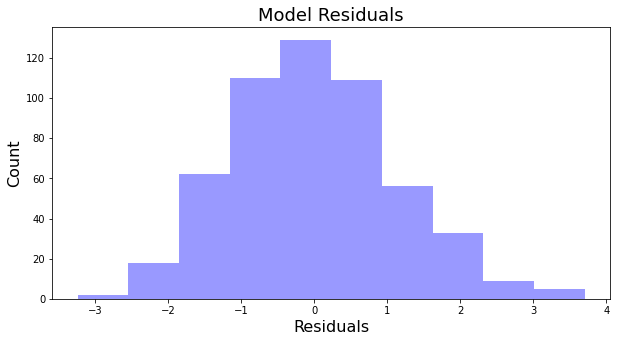

In [34]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=10)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.xlim([-2.2, 2.2])

(-1.0, 10.0)

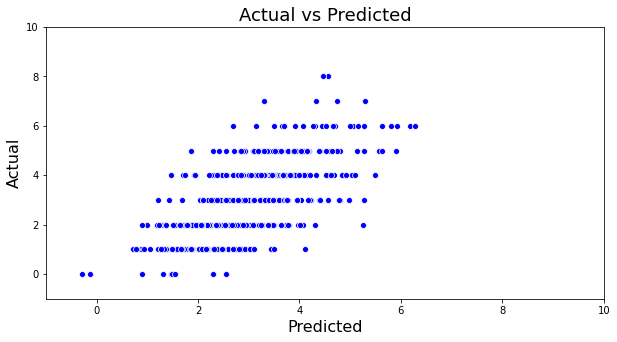

In [35]:
data['predictions'] = res.predict(X)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['predictions'], y=data['req_quality'], color='blue')
plt.title('Actual vs Predicted', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xlim([-1, 10])
plt.ylim([-1, 10])